<a href="https://colab.research.google.com/github/ComeBackCity/ML_Project/blob/main/Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from IPython.core.pylabtools import figsize
import itertools

# Processing the Dataset

In [3]:
alin_path = ''
gourab_path = '/content/drive/MyDrive/archive/'
path = gourab_path

In [4]:
path1 = path + 'Fish_Dataset/Fish_Dataset/'

In [11]:
folder_list = [x for x in os.listdir(path1) if '.' not in x]
folder_list

['Gilt-Head Bream',
 'Red Mullet',
 'Black Sea Sprat',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout',
 'TestSet']

In [12]:
folder_list = folder_list[:-1]
folder_list

['Gilt-Head Bream',
 'Red Mullet',
 'Black Sea Sprat',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [13]:
ds = []
for n,x in enumerate(folder_list):
    for i in os.listdir(path1+'/'+x+'/'+x):
        ds.append([path1+'/'+x+'/'+x+'/'+i,n,x])
df = pd.DataFrame(ds,columns=['Path','Label','Name'])
df.to_csv('/content/drive/MyDrive/archive/dataset.csv')

In [14]:
df.Name.unique()

array(['Gilt-Head Bream', 'Red Mullet', 'Black Sea Sprat',
       'Hourse Mackerel', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
       'Striped Red Mullet', 'Trout'], dtype=object)

In [15]:
classes = df.Name.value_counts().index
classes

Index(['Gilt-Head Bream', 'Red Mullet', 'Black Sea Sprat', 'Hourse Mackerel',
       'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout'],
      dtype='object')

# Visualizing the Dataset and Relevant Informations

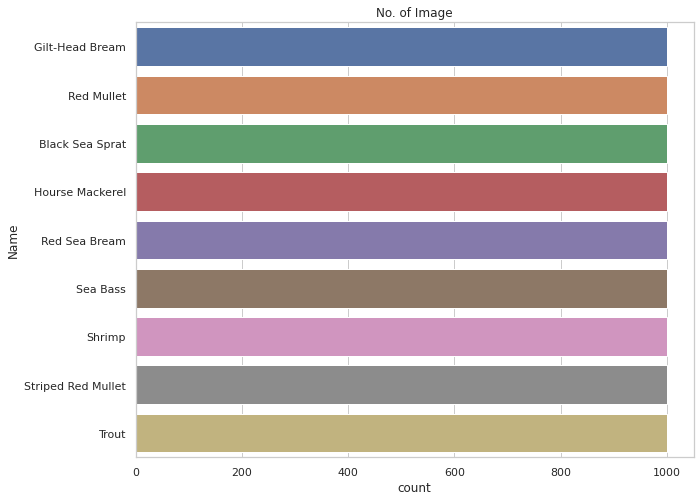

In [16]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))
ax = sns.countplot(y=df.Name)
ax.set_title('No. of Image');

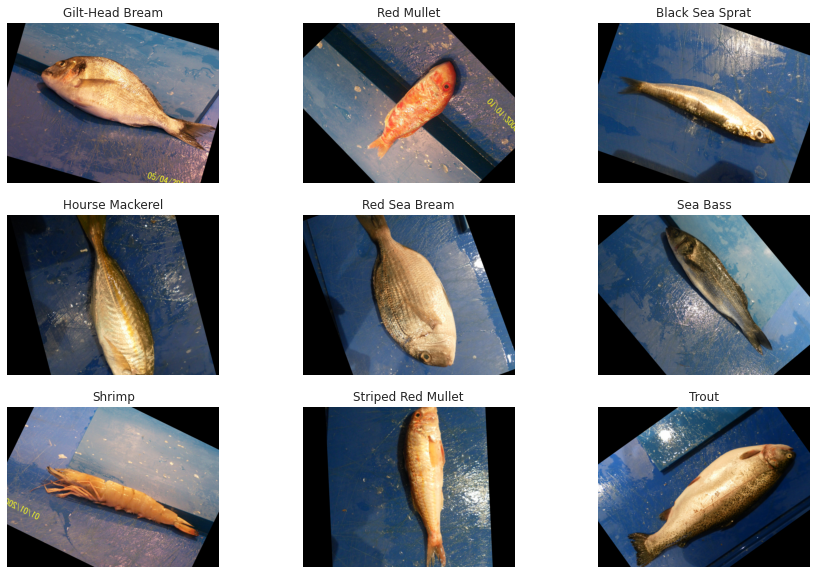

In [17]:
import random
fig, axs = plt.subplots(3,3,figsize=(15,10))
for i,x in enumerate(df.Name.value_counts().index):
    img = plt.imread(random.choice(df.loc[df.Name==df.Name.value_counts().index[i]].Path.to_list()))
    axs[int((i-i%3)/3),i%3].imshow(img)
    axs[int((i-i%3)/3),i%3].axis('off')
    axs[int((i-i%3)/3),i%3].set_title(x)

# Helper Functions

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((df.Path,df.Label))
def get_train_val_test_split(ds,shuffle : bool = True,shuffle_size : int =5000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*.8)
    val_size=int(ds_size*.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_train_val_test_split(dataset)

In [19]:
def load_images(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,(224,224))
    return image,label
def augment(image,label):
    image = tf.image.random_brightness(image,max_delta=.2)
    image = tf.image.random_flip_left_right(image)
    iamge = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.stateless_random_jpeg_quality(image,min_jpeg_quality=90,
                                                  max_jpeg_quality=100,
                                                  seed=(np.random.randint(100),
                                                       np.random.randint(100)))
    return image,label

In [20]:
BATCH_SIZE=32
train_ds = (train_ds
          .shuffle(len(train_ds)*100,seed=42)
          .map(load_images)
          .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))
test_ds =(test_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
val_ds =(val_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
batch = next(iter(train_ds))

# Model Related Functions

In [21]:
def build_model(model_url):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                        trainable=False,
                                        name='feature_extraction_layer',
                                        input_shape=(224,224,3))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(9,activation='softmax')
    ])

    return model


In [22]:
def train_model(model, training_set, validation_set, epochs):
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                                  patience=3,
                                                                  verbose=1,
                                                                  factor=.5,
                                                                  min_lr=.00001)
    
    history = model.fit(training_set,
                 epochs=epochs,
                 validation_data=validation_set,
                 callbacks=[learning_rate_reduction])
    
    return history

# Performance Functions

In [23]:
def plot_history(history):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    history_data = pd.DataFrame(history.history)
    sns.lineplot(data=history_data[['loss','val_loss']],ax=ax[0])
    sns.lineplot(data=history_data[['accuracy','val_accuracy']],ax=ax[1])
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs');

In [24]:
def get_report(model, test_set):
    test_data = [label.numpy() for example, label in test_set]
    y_test = np.concatenate(np.array(test_data))
    y_test_class = [classes[x] for x in y_test]
    y_pred = tf.argmax(model.predict(test_set),axis=1)
    y_pred_class = [classes[x] for x in y_pred]
    print(classification_report(y_test_class,y_pred_class))

In [25]:
def show_confusion_matrices(model, test_set):
    test_data = [label.numpy() for example, label in test_set]
    y_test = np.concatenate(np.array(test_data))
    y_test_class = [classes[x] for x in y_test]
    y_pred = tf.argmax(model.predict(test_set),axis=1)
    y_pred_class = [classes[x] for x in y_pred]
    confusion_matrices = multilabel_confusion_matrix(y_test_class, y_pred_class)

    labels = sorted(classes.to_list())
    
    f, axes = plt.subplots(3, 3, figsize=(25, 15))
    
    for i in range(9):
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrices[i])
        axes[i//3, i%3].grid(False)
        disp.plot(ax=axes[i//3, i%3])
        disp.ax_.set_title(labels[i])
        disp.im_.colorbar.remove()
        
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    f.colorbar(disp.im_, ax=axes)
    
    plt.show()

In [63]:
def show_9x9_confusion_matrix(model, test_set):
    test_data = [label.numpy() for example, label in test_set]
    y_test = np.concatenate(np.array(test_data))
    y_test_class = [classes[x] for x in y_test]
    y_pred = tf.argmax(model.predict(test_set),axis=1)
    y_pred_class = [classes[x] for x in y_pred]
    cm = confusion_matrix(y_test_class, y_pred_class)
    
    labels = sorted(classes.to_list())
    plt.figure(figsize=(25, 15))
    plt.imshow(cm, interpolation='nearest')
    plt.grid(False)
    plt.colorbar()

    labels = sorted(classes.to_list())
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] < 125 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Training and Performance

In [27]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5' # epoch = 20, lr = 0.001
inception_net_url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5' # epoch = 20, lr = 0.001
resnet50_url = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1' # epoch = 20, lr = 0.001
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1' # epoch = 20, lr = 0.001
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2' # epoch = 20, lr = 0.001
vision_transformer = 'https://tfhub.dev/sayakpaul/vit_b16_fe/1' # epoch = 7 lr = 0.001 # best performance
bit_url = 'https://tfhub.dev/google/bit/s-r101x3/1'  # epoch = 7 lr = 0.001

url = mobilenet_url

model = build_model(url)

optimizer = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

history = train_model(model, train_ds, val_ds, epochs=10)

Epoch 1/10
225/225 [==============================] - 806s 4s/step - loss: 0.2619 - accuracy: 0.9414 - val_loss: 0.1112 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/10
225/225 [==============================] - 7s 30ms/step - loss: 0.0297 - accuracy: 0.9986 - val_loss: 0.0745 - val_accuracy: 0.9822 - lr: 0.0010
Epoch 3/10
225/225 [==============================] - 7s 30ms/step - loss: 0.0150 - accuracy: 0.9994 - val_loss: 0.0597 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 4/10
225/225 [==============================] - 7s 30ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 5/10
225/225 [==============================] - 7s 30ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0469 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 6/10
225/225 [==============================] - 7s 31ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 7/10
225/225 [==============================] - 7s 31ms/st

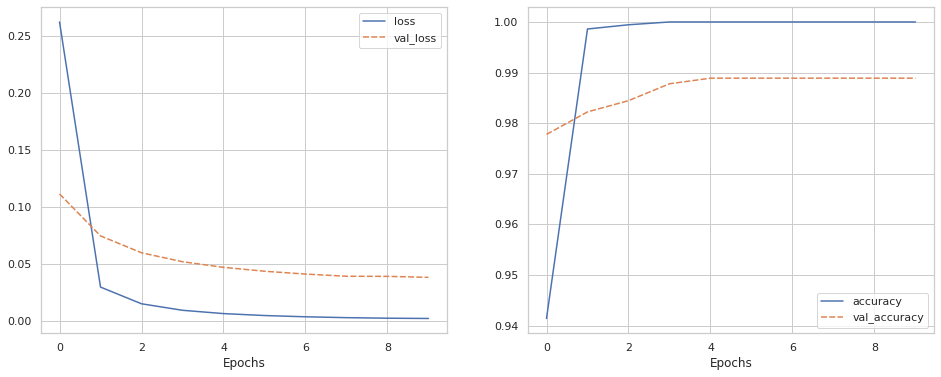

In [28]:
plot_history(history)

In [29]:
get_report(model, test_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        88
   Gilt-Head Bream       1.00      1.00      1.00        91
   Hourse Mackerel       1.00      1.00      1.00        79
        Red Mullet       1.00      1.00      1.00        90
     Red Sea Bream       1.00      1.00      1.00        70
          Sea Bass       0.93      1.00      0.96        90
            Shrimp       0.99      1.00      1.00       104
Striped Red Mullet       1.00      0.99      1.00       132
             Trout       1.00      0.96      0.98       156

          accuracy                           0.99       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       0.99      0.99      0.99       900



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


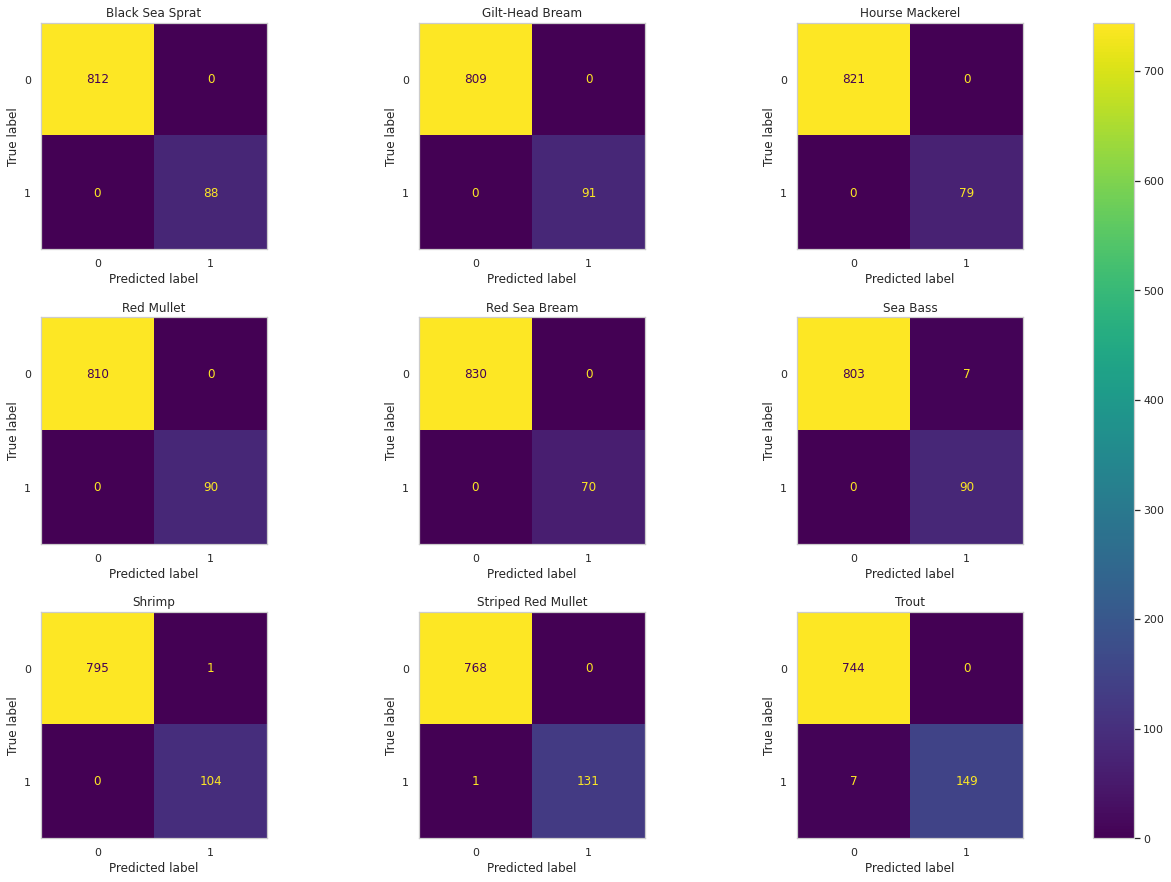

In [30]:
show_confusion_matrices(model, test_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


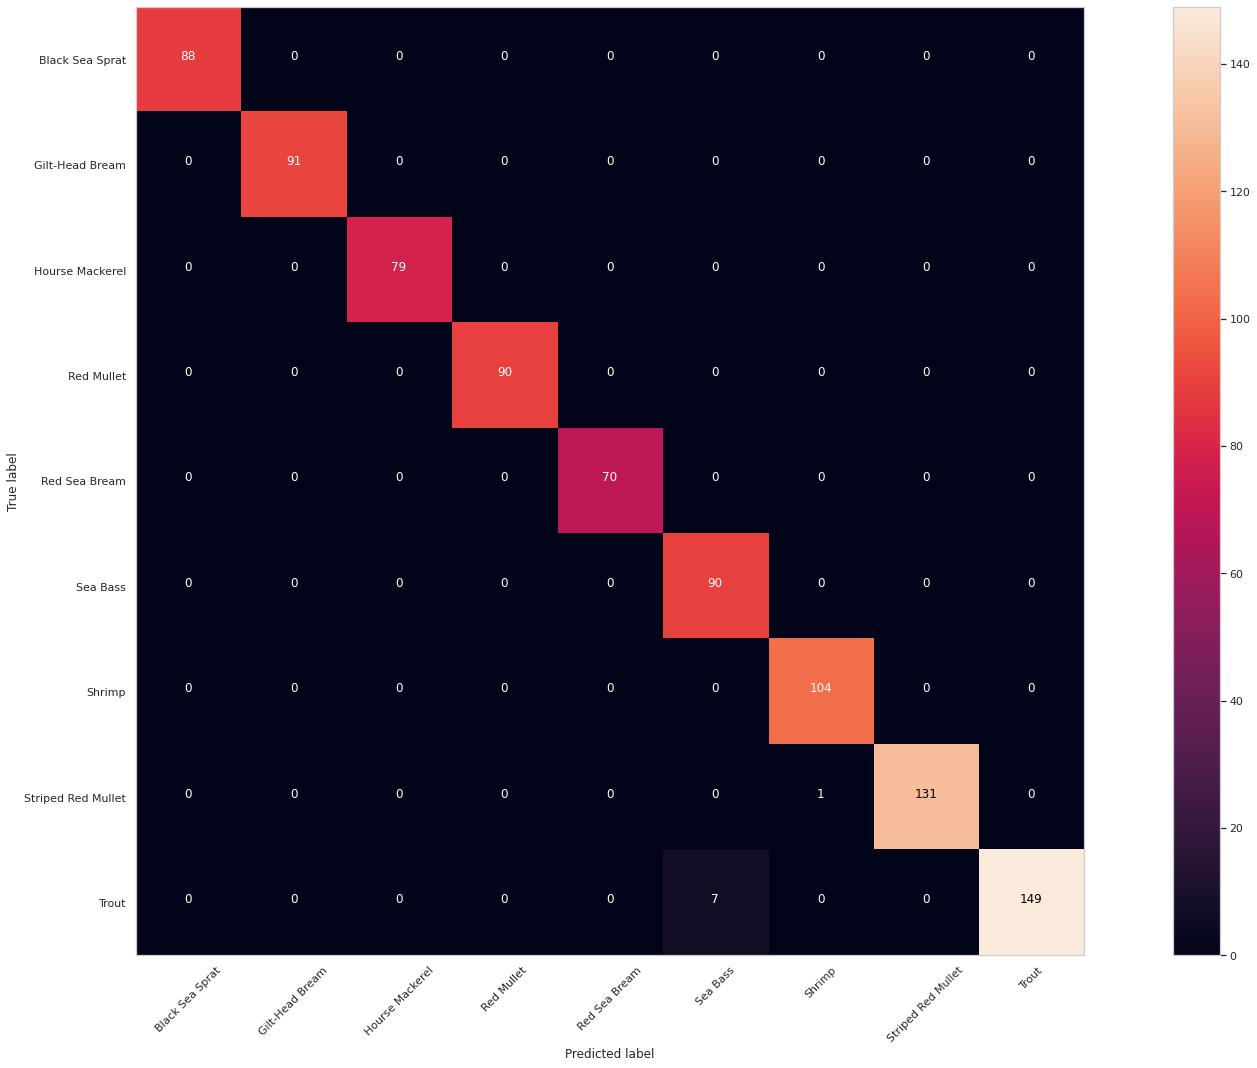

In [64]:
show_9x9_confusion_matrix(model, test_ds)